In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import joblib

In [3]:
df = pd.read_csv('dataset.csv')
classes = joblib.load('class_dict.joblib')
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f4087,f4088,f4089,f4090,f4091,f4092,f4093,f4094,f4095,class
0,66.0,83.0,83.0,61.0,78.0,87.0,49.0,70.0,85.0,63.0,...,38.0,42.0,65.0,56.0,56.0,51.0,49.0,39.0,39.0,0
1,39.0,49.0,66.0,28.0,35.0,45.0,2.0,16.0,22.0,29.0,...,202.0,101.0,77.0,78.0,109.0,225.0,219.0,219.0,223.0,0
2,129.0,138.0,148.0,140.0,149.0,158.0,144.0,154.0,164.0,149.0,...,189.0,41.0,15.0,231.0,226.0,223.0,251.0,52.0,54.0,0
3,114.0,45.0,36.0,113.0,40.0,32.0,110.0,38.0,30.0,109.0,...,79.0,42.0,178.0,196.0,244.0,245.0,0.0,0.0,196.0,0
4,9.0,14.0,12.0,9.0,14.0,13.0,22.0,27.0,26.0,20.0,...,201.0,28.0,241.0,228.0,230.0,212.0,226.0,242.0,235.0,0


In [4]:
X = df.drop("class",axis = "columns")
y = df['class']

In [5]:
# Training our model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y)
pipeline = Pipeline( [ ('scaler',StandardScaler() ), ( 'svc',SVC(kernel = "rbf",C = 10) ) ])
pipeline.fit(x_train,y_train)

y_pred = pipeline.predict(x_test)
print(pipeline.score(x_test,y_test))

0.8666666666666667


In [6]:
cr = classification_report(y_test,y_pred)
print(cr)
#print(set(y_test)-set(y_pred))

              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       1.00      0.91      0.95        11
           2       0.76      1.00      0.86        16
           3       1.00      1.00      1.00        10

    accuracy                           0.87        45
   macro avg       0.88      0.82      0.83        45
weighted avg       0.87      0.87      0.85        45



In [7]:
# Using Grid Search To find best model
model_params = {
    "svm":{
        'model': SVC(gamma = "auto",probability = True),
        'params':{
                    'svc__C' : [1,10,100,1000],
                    'svc__kernel':['rbf','linear'],
        }
    },
    "random_forest":{
        'model': RandomForestClassifier(),
        'params':{
            'randomforestclassifier__n_estimators':[10,20,100]
        }
    },
    "logistic_regression":{
        'model': LogisticRegression(solver = "liblinear",multi_class = "auto"),
        'params':{
            'logisticregression__C':[1,5,10]
        }
    }
}

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
scores_list = []
best_estimator_dict = {}

for model_name,mp in model_params.items():
    pipeline = make_pipeline( StandardScaler(),mp['model'] )
    model = GridSearchCV(pipeline,mp['params'],cv = 5,return_train_score = False)
    model.fit(x_train,y_train)
    scores_list.append({
        'model':model_name,
        'best_score':model.best_score_,
        'best_params':model.best_params_,
    })
    best_estimator_dict[model_name] = model.best_estimator_

 


In [14]:
scores_df = pd.DataFrame(scores_list)
scores_df.to_csv('GridSearchCV_results.csv',index = False)

In [15]:
scores_df

,model,best_score,best_params
0,svm,0.892540,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.774286,{'randomforestclassifier__n_estimators': 100}
2,logistic_regression,0.898254,{'logisticregression__C': 1}


In [16]:
best_estimator_dict

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [17]:
best_estimator_dict['svm'].score(x_test,y_test)

0.8888888888888888

In [18]:
best_estimator_dict['random_forest'].score(x_test,y_test)

0.8

In [19]:
best_estimator_dict['logistic_regression'].score(x_test,y_test)

0.9111111111111111

In [20]:
# From this we know that best model could be svm or logistic regression both giving good scores
svm_best = best_estimator_dict['svm']
lr_best = best_estimator_dict['logistic_regression']

In [21]:
y_pred_svm = svm_best.predict(x_test)
y_pred_lr = lr_best.predict(x_test)

In [22]:
cm = confusion_matrix(y_test,y_pred_svm)
cm

array([[ 4,  0,  4,  0],
       [ 1, 10,  0,  0],
       [ 0,  0, 16,  0],
       [ 0,  0,  0, 10]], dtype=int64)

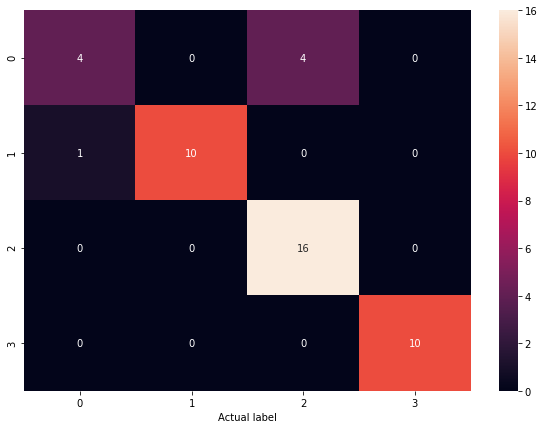

In [28]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot = True)
plt.xlabel('predicted label')
plt.xlabel('Actual label')
plt.show()

In [30]:
cm = confusion_matrix(y_test,y_pred_lr)
cm

array([[ 5,  0,  3,  0],
       [ 0, 11,  0,  0],
       [ 1,  0, 15,  0],
       [ 0,  0,  0, 10]], dtype=int64)

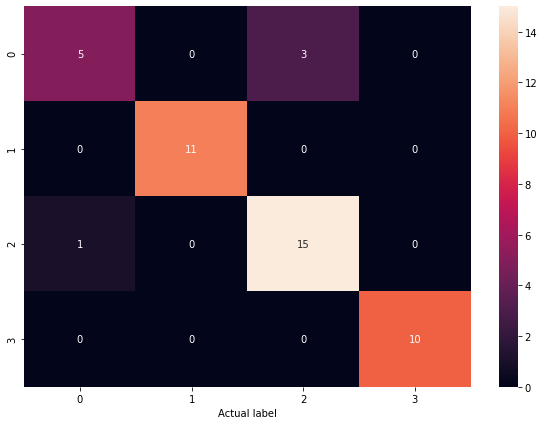

In [31]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot = True)
plt.xlabel('predicted label')
plt.xlabel('Actual label')
plt.show()

In [34]:
cr_svm = classification_report(y_test,y_pred_svm)
cr_lr = classification_report(y_test,y_pred_lr)

In [35]:
print(cr_svm)

              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       1.00      0.91      0.95        11
           2       0.80      1.00      0.89        16
           3       1.00      1.00      1.00        10

    accuracy                           0.89        45
   macro avg       0.90      0.85      0.86        45
weighted avg       0.89      0.89      0.88        45



In [36]:
print(cr_lr)

              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       1.00      1.00      1.00        11
           2       0.83      0.94      0.88        16
           3       1.00      1.00      1.00        10

    accuracy                           0.91        45
   macro avg       0.92      0.89      0.90        45
weighted avg       0.91      0.91      0.91        45



In [37]:
import joblib
joblib.dump(lr_best,"best_model_lr.joblib")
joblib.dump(svm_best,"best_model_svm.joblib")

['best_model_svm.joblib']